In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix
from sklearn.model_selection import train_test_split
import sys
sys.path.insert(0, "..")


# Load Data

In [22]:
! curl -L -o ../assets/archive.zip https://www.kaggle.com/api/v1/datasets/download/mlg-ulb/creditcardfraud


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

  0 65.9M    0  189k    0     0   145k      0  0:07:43  0:00:01  0:07:42  145k
  1 65.9M    1  739k    0     0   319k      0  0:03:31  0:00:02  0:03:29  543k
  1 65.9M    1 1182k    0     0   359k      0  0:03:07  0:00:03  0:03:04  499k
  2 65.9M    2 1808k    0     0   420k      0  0:02:40  0:00:04  0:02:36  540k
  3 65.9M    3 2318k    0     0   438k      0  0:02:34  0:00:05  0:02:29  533k
  4 65.9M    4 2814k    0     0   447k      0  0:02:31  0:00:06  0:02:25  525k
  4 65.9M    4 3358k    0     0   458k      0  0:02:27  0:00:07  0:02:20  522k
  5 65.9M    5 3870k    0     0   466k      0  0:0

In [23]:
! tar -xf ../assets/archive.zip -C ../assets/

In [24]:
data = pd.read_csv("../assets/creditcard.csv")

In [25]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [26]:
FEATURES = [f'V{i}' for i in range(1,29)] + ['Amount']
TARGET = 'Class'
SEED = 42


In [27]:
data['label'] = data.Class.apply(lambda x: "Fraud" if x==1 else "Not Fraud")
data['time_hr'] = np.floor(data['Time']/3600)
data['time_hr']= data['time_hr'].astype(int)

In [28]:
data_train, data_test = train_test_split(data, test_size=0.25, stratify=data[TARGET], random_state=SEED)

# EDA

## Describe

In [29]:
(100*data.label.value_counts()/data.shape[0]).to_frame().style.format("{:.2f}%")

,count
label,
Not Fraud,99.83%
Fraud,0.17%


In [30]:
data_train[FEATURES].describe().style.format('{:.3f}')

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
count,213605.000,213605.000,213605.000,213605.000,213605.000,213605.000,213605.000,213605.000,213605.000,213605.000,213605.000,213605.000,213605.000,213605.000,213605.000,213605.000,213605.000,213605.000,213605.000,213605.000,213605.000,213605.000,213605.000,213605.000,213605.000,213605.000,213605.000,213605.000,213605.000
mean,-0.001,-0.001,-0.001,-0.002,0.000,-0.001,-0.001,-0.001,0.001,-0.000,-0.001,0.001,-0.001,-0.000,0.001,-0.001,0.000,-0.000,-0.000,-0.001,0.000,0.000,0.000,-0.000,-0.000,-0.000,-0.000,0.000,88.217
std,1.962,1.651,1.517,1.416,1.384,1.334,1.242,1.194,1.098,1.088,1.020,0.999,0.994,0.958,0.915,0.876,0.847,0.840,0.814,0.770,0.736,0.726,0.624,0.605,0.521,0.482,0.405,0.326,250.522
min,-56.408,-72.716,-48.326,-5.683,-113.743,-26.161,-43.557,-73.217,-13.434,-24.588,-4.797,-18.684,-5.792,-19.214,-4.499,-14.130,-25.163,-9.499,-7.214,-54.498,-34.830,-10.933,-44.808,-2.837,-10.295,-2.605,-22.566,-15.430,0.000
25%,-0.920,-0.600,-0.892,-0.849,-0.692,-0.769,-0.554,-0.208,-0.640,-0.536,-0.763,-0.404,-0.649,-0.426,-0.581,-0.470,-0.483,-0.499,-0.456,-0.212,-0.228,-0.542,-0.162,-0.355,-0.317,-0.327,-0.071,-0.053,5.640
50%,0.018,0.065,0.180,-0.022,-0.055,-0.275,0.040,0.023,-0.051,-0.094,-0.033,0.141,-0.015,0.049,0.048,0.065,-0.066,-0.003,0.004,-0.063,-0.030,0.006,-0.011,0.041,0.017,-0.052,0.001,0.011,22.000
75%,1.315,0.805,1.026,0.742,0.612,0.398,0.571,0.328,0.599,0.455,0.738,0.619,0.661,0.492,0.649,0.521,0.401,0.500,0.458,0.133,0.186,0.528,0.148,0.439,0.350,0.241,0.091,0.078,77.500
max,2.452,22.058,9.383,16.875,34.802,73.302,120.589,20.007,15.595,23.745,12.019,7.848,7.127,10.527,8.878,17.315,9.254,5.041,5.572,39.421,27.203,10.503,22.084,4.585,6.071,3.517,31.612,33.848,25691.160


In [31]:
data_train[FEATURES[:8]+["Amount"]].describe().style.format('{:.3f}')

,V1,V2,V3,V4,V5,V6,V7,V8,Amount
count,213605.000,213605.000,213605.000,213605.000,213605.000,213605.000,213605.000,213605.000,213605.000
mean,-0.001,-0.001,-0.001,-0.002,0.000,-0.001,-0.001,-0.001,88.217
std,1.962,1.651,1.517,1.416,1.384,1.334,1.242,1.194,250.522
min,-56.408,-72.716,-48.326,-5.683,-113.743,-26.161,-43.557,-73.217,0.000
25%,-0.920,-0.600,-0.892,-0.849,-0.692,-0.769,-0.554,-0.208,5.640
50%,0.018,0.065,0.180,-0.022,-0.055,-0.275,0.040,0.023,22.000
75%,1.315,0.805,1.026,0.742,0.612,0.398,0.571,0.328,77.500
max,2.452,22.058,9.383,16.875,34.802,73.302,120.589,20.007,25691.160


## Scatter Plot

<Axes: xlabel='V4', ylabel='V14'>

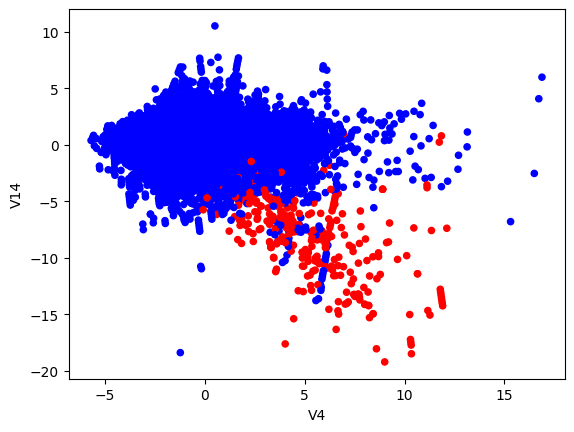

In [32]:
col = data_train.Class.map({0:'b', 1:'r'})
data_train.plot.scatter(x='V4',y='V14',c=col)

## Temporal Stability

In [33]:
from src.report import plot_time_stab, bin_var

In [34]:
data_train['time_hr'] = np.floor(data_train['Time']/3600)
data_train['time_hr']= data_train['time_hr'].astype(int)

In [35]:
data_agg_time = data_train.groupby(['time_hr']).agg(avg_amount=('Amount','mean'),
                              count=('Time','count'),
                              bad=('Class','sum')
                              ).reset_index()

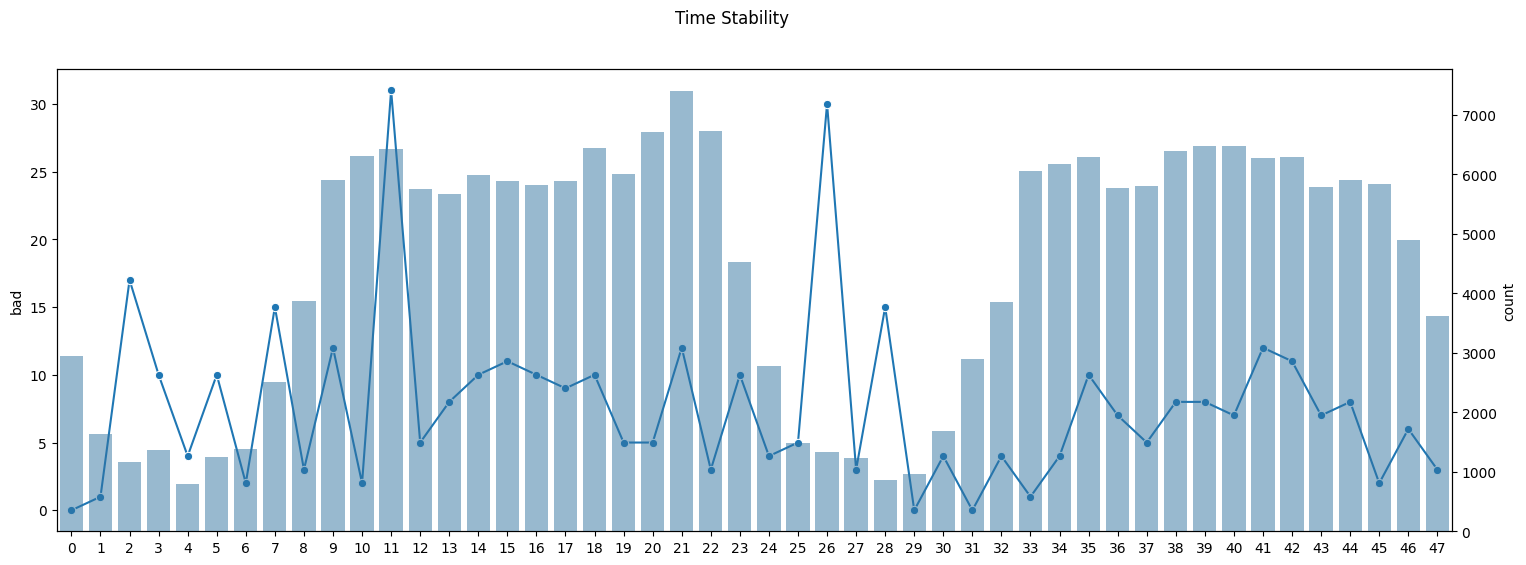

In [36]:
plot_time_stab(data_agg_time)

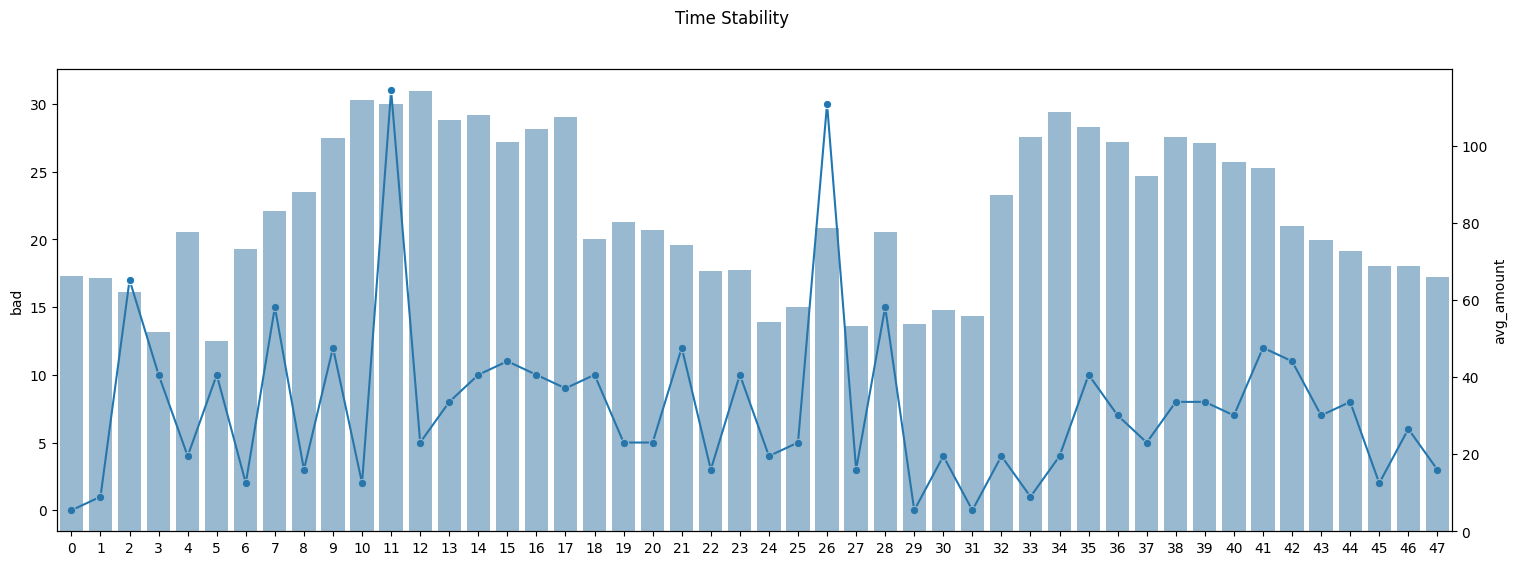

In [37]:
plot_time_stab(data_agg_time, bar_y_col='avg_amount')

## Binned Variables

In [38]:
def _bin_var(data, col, n_bins=10): 
    df = data.copy()
    col_binned = col+'_binned'
    cmap = sns.light_palette("red", as_cmap=True)
    df[col_binned] = pd.qcut(df[col],q=n_bins)
    df_agg = df.groupby(col_binned).agg(
                              count=(col,'count'),
                              bad=('Class','sum')
                              ).reset_index()
    df_agg['bad_rate'] = df_agg.bad/df_agg['count']
    df_agg['bad_distr'] = df_agg.bad/df_agg.bad.sum()
    view  = df_agg.style.background_gradient(subset=['bad_rate','bad_distr'],cmap=cmap,vmax=1).format("{:.3f}",subset=["bad_rate","bad_distr"])
    return view

In [39]:
binned_dfs = []
for f in FEATURES:
    print(f)
    binned_dfs.append(bin_var(data,f))
    display(bin_var(data,f))


V1


,V1_binned,count,event,event_rate,event_distr
0,"(-56.409, -1.893]",28481,276,0.969%,56.098%
1,"(-1.893, -1.135]",28481,50,0.176%,10.163%
2,"(-1.135, -0.747]",28480,25,0.088%,5.081%
3,"(-0.747, -0.427]",28481,17,0.060%,3.455%
4,"(-0.427, 0.0181]",28481,20,0.070%,4.065%
5,"(0.0181, 1.035]",28480,53,0.186%,10.772%
6,"(1.035, 1.225]",28481,27,0.095%,5.488%
7,"(1.225, 1.695]",28480,10,0.035%,2.033%
8,"(1.695, 2.015]",28481,12,0.042%,2.439%
9,"(2.015, 2.455]",28481,2,0.007%,0.407%


V2


,V2_binned,count,event,event_rate,event_distr
0,"(-72.717, -1.36]",28481,23,0.081%,4.675%
1,"(-1.36, -0.791]",28481,9,0.032%,1.829%
2,"(-0.791, -0.436]",28480,8,0.028%,1.626%
3,"(-0.436, -0.154]",28481,7,0.025%,1.423%
4,"(-0.154, 0.0655]",28481,11,0.039%,2.236%
5,"(0.0655, 0.303]",28480,6,0.021%,1.220%
6,"(0.303, 0.637]",28481,17,0.060%,3.455%
7,"(0.637, 0.957]",28480,16,0.056%,3.252%
8,"(0.957, 1.327]",28481,39,0.137%,7.927%
9,"(1.327, 22.058]",28481,356,1.250%,72.358%


V3


,V3_binned,count,event,event_rate,event_distr
0,"(-48.327, -1.803]",28481,389,1.366%,79.065%
1,"(-1.803, -1.169]",28481,28,0.098%,5.691%
2,"(-1.169, -0.617]",28480,20,0.070%,4.065%
3,"(-0.617, -0.199]",28481,17,0.060%,3.455%
4,"(-0.199, 0.18]",28481,9,0.032%,1.829%
5,"(0.18, 0.497]",28480,6,0.021%,1.220%
6,"(0.497, 0.844]",28481,8,0.028%,1.626%
7,"(0.844, 1.216]",28480,9,0.032%,1.829%
8,"(1.216, 1.676]",28481,2,0.007%,0.407%
9,"(1.676, 9.383]",28481,4,0.014%,0.813%


V4


,V4_binned,count,event,event_rate,event_distr
0,"(-5.684, -1.656]",28481,0,0.000%,0.000%
1,"(-1.656, -1.066]",28481,2,0.007%,0.407%
2,"(-1.066, -0.696]",28480,1,0.004%,0.203%
3,"(-0.696, -0.394]",28481,5,0.018%,1.016%
4,"(-0.394, -0.0198]",28481,5,0.018%,1.016%
5,"(-0.0198, 0.285]",28480,10,0.035%,2.033%
6,"(0.285, 0.559]",28481,9,0.032%,1.829%
7,"(0.559, 0.986]",28480,13,0.046%,2.642%
8,"(0.986, 1.483]",28481,25,0.088%,5.081%
9,"(1.483, 16.875]",28481,422,1.482%,85.772%


V5


,V5_binned,count,event,event_rate,event_distr
0,"(-113.744, -1.302]",28481,256,0.899%,52.033%
1,"(-1.302, -0.86]",28481,34,0.119%,6.911%
2,"(-0.86, -0.544]",28480,27,0.095%,5.488%
3,"(-0.544, -0.29]",28481,18,0.063%,3.659%
4,"(-0.29, -0.0543]",28481,16,0.056%,3.252%
5,"(-0.0543, 0.187]",28480,15,0.053%,3.049%
6,"(0.187, 0.457]",28481,21,0.074%,4.268%
7,"(0.457, 0.802]",28481,24,0.084%,4.878%
8,"(0.802, 1.408]",28480,33,0.116%,6.707%
9,"(1.408, 34.802]",28481,48,0.169%,9.756%


V6


,V6_binned,count,event,event_rate,event_distr
0,"(-26.162000000000003, -1.167]",28481,284,0.997%,57.724%
1,"(-1.167, -0.878]",28481,32,0.112%,6.504%
2,"(-0.878, -0.668]",28480,22,0.077%,4.472%
3,"(-0.668, -0.479]",28481,26,0.091%,5.285%
4,"(-0.479, -0.274]",28481,21,0.074%,4.268%
5,"(-0.274, -0.0482]",28480,25,0.088%,5.081%
6,"(-0.0482, 0.223]",28481,19,0.067%,3.862%
7,"(0.223, 0.629]",28480,15,0.053%,3.049%
8,"(0.629, 1.509]",28481,27,0.095%,5.488%
9,"(1.509, 73.302]",28481,21,0.074%,4.268%


V7


,V7_binned,count,event,event_rate,event_distr
0,"(-43.558, -1.078]",28481,364,1.278%,73.984%
1,"(-1.078, -0.683]",28481,23,0.081%,4.675%
2,"(-0.683, -0.426]",28480,7,0.025%,1.423%
3,"(-0.426, -0.159]",28481,6,0.021%,1.220%
4,"(-0.159, 0.0401]",28481,11,0.039%,2.236%
5,"(0.0401, 0.214]",28480,8,0.028%,1.626%
6,"(0.214, 0.446]",28481,20,0.070%,4.065%
7,"(0.446, 0.698]",28480,10,0.035%,2.033%
8,"(0.698, 1.039]",28481,10,0.035%,2.033%
9,"(1.039, 120.589]",28481,33,0.116%,6.707%


V8


,V8_binned,count,event,event_rate,event_distr
0,"(-73.218, -0.459]",28481,93,0.327%,18.902%
1,"(-0.459, -0.266]",28481,21,0.074%,4.268%
2,"(-0.266, -0.158]",28480,13,0.046%,2.642%
3,"(-0.158, -0.0661]",28481,13,0.046%,2.642%
4,"(-0.0661, 0.0224]",28481,12,0.042%,2.439%
5,"(0.0224, 0.12]",28480,21,0.074%,4.268%
6,"(0.12, 0.243]",28481,19,0.067%,3.862%
7,"(0.243, 0.436]",28480,27,0.095%,5.488%
8,"(0.436, 0.769]",28481,55,0.193%,11.179%
9,"(0.769, 20.007]",28481,218,0.765%,44.309%


V9


,V9_binned,count,event,event_rate,event_distr
0,"(-13.434999999999999, -1.294]",28481,327,1.148%,66.463%
1,"(-1.294, -0.809]",28481,38,0.133%,7.724%
2,"(-0.809, -0.502]",28480,29,0.102%,5.894%
3,"(-0.502, -0.258]",28481,18,0.063%,3.659%
4,"(-0.258, -0.0514]",28481,19,0.067%,3.862%
5,"(-0.0514, 0.176]",28480,14,0.049%,2.846%
6,"(0.176, 0.446]",28481,10,0.035%,2.033%
7,"(0.446, 0.792]",28480,12,0.042%,2.439%
8,"(0.792, 1.302]",28481,18,0.063%,3.659%
9,"(1.302, 15.595]",28481,7,0.025%,1.423%


V10


,V10_binned,count,event,event_rate,event_distr
0,"(-24.589000000000002, -1.032]",28481,417,1.464%,84.756%
1,"(-1.032, -0.666]",28481,12,0.042%,2.439%
2,"(-0.666, -0.426]",28480,7,0.025%,1.423%
3,"(-0.426, -0.248]",28481,7,0.025%,1.423%
4,"(-0.248, -0.0929]",28481,7,0.025%,1.423%
5,"(-0.0929, 0.0595]",28480,6,0.021%,1.220%
6,"(0.0595, 0.27]",28481,9,0.032%,1.829%
7,"(0.27, 0.648]",28480,11,0.039%,2.236%
8,"(0.648, 1.12]",28481,7,0.025%,1.423%
9,"(1.12, 23.745]",28481,9,0.032%,1.829%


V11


,V11_binned,count,event,event_rate,event_distr
0,"(-4.798, -1.289]",28481,7,0.025%,1.423%
1,"(-1.289, -0.917]",28481,6,0.021%,1.220%
2,"(-0.917, -0.613]",28480,5,0.018%,1.016%
3,"(-0.613, -0.317]",28481,10,0.035%,2.033%
4,"(-0.317, -0.0328]",28481,3,0.011%,0.610%
5,"(-0.0328, 0.268]",28480,10,0.035%,2.033%
6,"(0.268, 0.579]",28481,9,0.032%,1.829%
7,"(0.579, 0.913]",28480,15,0.053%,3.049%
8,"(0.913, 1.319]",28481,23,0.081%,4.675%
9,"(1.319, 12.019]",28481,404,1.418%,82.114%


V12


,V12_binned,count,event,event_rate,event_distr
0,"(-18.685000000000002, -1.148]",28481,414,1.454%,84.146%
1,"(-1.148, -0.573]",28481,23,0.081%,4.675%
2,"(-0.573, -0.272]",28481,20,0.070%,4.065%
3,"(-0.272, -0.0505]",28480,8,0.028%,1.626%
4,"(-0.0505, 0.14]",28481,6,0.021%,1.220%
5,"(0.14, 0.325]",28480,7,0.025%,1.423%
6,"(0.325, 0.516]",28481,3,0.011%,0.610%
7,"(0.516, 0.731]",28480,3,0.011%,0.610%
8,"(0.731, 1.017]",28481,6,0.021%,1.220%
9,"(1.017, 7.848]",28481,2,0.007%,0.407%


V13


,V13_binned,count,event,event_rate,event_distr
0,"(-5.793, -1.28]",28481,74,0.260%,15.041%
1,"(-1.28, -0.825]",28481,67,0.235%,13.618%
2,"(-0.825, -0.497]",28480,39,0.137%,7.927%
3,"(-0.497, -0.24]",28481,36,0.126%,7.317%
4,"(-0.24, -0.0136]",28481,33,0.116%,6.707%
5,"(-0.0136, 0.229]",28480,37,0.130%,7.520%
6,"(0.229, 0.505]",28481,52,0.183%,10.569%
7,"(0.505, 0.829]",28480,58,0.204%,11.789%
8,"(0.829, 1.252]",28481,41,0.144%,8.333%
9,"(1.252, 7.127]",28481,55,0.193%,11.179%


V14


,V14_binned,count,event,event_rate,event_distr
0,"(-19.215, -1.004]",28481,445,1.562%,90.447%
1,"(-1.004, -0.567]",28481,12,0.042%,2.439%
2,"(-0.567, -0.312]",28480,7,0.025%,1.423%
3,"(-0.312, -0.12]",28481,3,0.011%,0.610%
4,"(-0.12, 0.0506]",28481,3,0.011%,0.610%
5,"(0.0506, 0.216]",28480,3,0.011%,0.610%
6,"(0.216, 0.394]",28481,4,0.014%,0.813%
7,"(0.394, 0.609]",28480,2,0.007%,0.407%
8,"(0.609, 0.981]",28481,3,0.011%,0.610%
9,"(0.981, 10.527]",28481,10,0.035%,2.033%


V15


,V15_binned,count,event,event_rate,event_distr
0,"(-4.5, -1.174]",28481,74,0.260%,15.041%
1,"(-1.174, -0.749]",28481,37,0.130%,7.520%
2,"(-0.749, -0.439]",28480,39,0.137%,7.927%
3,"(-0.439, -0.189]",28481,66,0.232%,13.415%
4,"(-0.189, 0.0481]",28481,55,0.193%,11.179%
5,"(0.0481, 0.272]",28503,30,0.105%,6.098%
6,"(0.272, 0.514]",28458,45,0.158%,9.146%
7,"(0.514, 0.795]",28480,47,0.165%,9.553%
8,"(0.795, 1.124]",28481,52,0.183%,10.569%
9,"(1.124, 8.878]",28481,47,0.165%,9.553%


V16


,V16_binned,count,event,event_rate,event_distr
0,"(-14.131, -1.059]",28481,377,1.324%,76.626%
1,"(-1.059, -0.616]",28481,21,0.074%,4.268%
2,"(-0.616, -0.343]",28480,9,0.032%,1.829%
3,"(-0.343, -0.125]",28481,3,0.011%,0.610%
4,"(-0.125, 0.0664]",28481,5,0.018%,1.016%
5,"(0.0664, 0.242]",28480,9,0.032%,1.829%
6,"(0.242, 0.426]",28481,9,0.032%,1.829%
7,"(0.426, 0.641]",28480,11,0.039%,2.236%
8,"(0.641, 0.991]",28481,14,0.049%,2.846%
9,"(0.991, 17.315]",28481,34,0.119%,6.911%


V17


,V17_binned,count,event,event_rate,event_distr
0,"(-25.164, -0.804]",28481,378,1.327%,76.829%
1,"(-0.804, -0.576]",28481,1,0.004%,0.203%
2,"(-0.576, -0.397]",28480,3,0.011%,0.610%
3,"(-0.397, -0.236]",28481,2,0.007%,0.407%
4,"(-0.236, -0.0657]",28481,7,0.025%,1.423%
5,"(-0.0657, 0.105]",28480,6,0.021%,1.220%
6,"(0.105, 0.297]",28481,8,0.028%,1.626%
7,"(0.297, 0.519]",28480,7,0.025%,1.423%
8,"(0.519, 0.909]",28481,21,0.074%,4.268%
9,"(0.909, 9.254]",28481,59,0.207%,11.992%


V18


,V18_binned,count,event,event_rate,event_distr
0,"(-9.5, -0.977]",28481,293,1.029%,59.553%
1,"(-0.977, -0.627]",28481,27,0.095%,5.488%
2,"(-0.627, -0.386]",28480,13,0.046%,2.642%
3,"(-0.386, -0.186]",28481,10,0.035%,2.033%
4,"(-0.186, -0.00364]",28481,20,0.070%,4.065%
5,"(-0.00364, 0.182]",28480,17,0.060%,3.455%
6,"(0.182, 0.383]",28481,24,0.084%,4.878%
7,"(0.383, 0.637]",28480,17,0.060%,3.455%
8,"(0.637, 1.02]",28481,20,0.070%,4.065%
9,"(1.02, 5.041]",28481,51,0.179%,10.366%


V19


,V19_binned,count,event,event_rate,event_distr
0,"(-7.215000000000001, -0.986]",28481,75,0.263%,15.244%
1,"(-0.986, -0.583]",28481,25,0.088%,5.081%
2,"(-0.583, -0.345]",28480,21,0.074%,4.268%
3,"(-0.345, -0.162]",28481,16,0.056%,3.252%
4,"(-0.162, 0.00373]",28481,14,0.049%,2.846%
5,"(0.00373, 0.168]",28480,24,0.084%,4.878%
6,"(0.168, 0.348]",28481,21,0.074%,4.268%
7,"(0.348, 0.586]",28480,35,0.123%,7.114%
8,"(0.586, 0.954]",28481,59,0.207%,11.992%
9,"(0.954, 5.592]",28481,202,0.709%,41.057%


V20


,V20_binned,count,event,event_rate,event_distr
0,"(-54.498999999999995, -0.39]",28481,80,0.281%,16.260%
1,"(-0.39, -0.251]",28481,16,0.056%,3.252%
2,"(-0.251, -0.179]",28480,22,0.077%,4.472%
3,"(-0.179, -0.121]",28481,21,0.074%,4.268%
4,"(-0.121, -0.0625]",28481,18,0.063%,3.659%
5,"(-0.0625, 0.00431]",28480,21,0.074%,4.268%
6,"(0.00431, 0.0834]",28481,19,0.067%,3.862%
7,"(0.0834, 0.196]",28480,22,0.077%,4.472%
8,"(0.196, 0.445]",28481,80,0.281%,16.260%
9,"(0.445, 39.421]",28481,193,0.678%,39.228%


V21


,V21_binned,count,event,event_rate,event_distr
0,"(-34.830999999999996, -0.367]",28481,70,0.246%,14.228%
1,"(-0.367, -0.266]",28481,14,0.049%,2.846%
2,"(-0.266, -0.188]",28480,1,0.004%,0.203%
3,"(-0.188, -0.106]",28481,13,0.046%,2.642%
4,"(-0.106, -0.0295]",28481,15,0.053%,3.049%
5,"(-0.0295, 0.0504]",28480,11,0.039%,2.236%
6,"(0.0504, 0.138]",28481,15,0.053%,3.049%
7,"(0.138, 0.235]",28480,19,0.067%,3.862%
8,"(0.235, 0.376]",28481,35,0.123%,7.114%
9,"(0.376, 27.203]",28481,299,1.050%,60.772%


V22


,V22_binned,count,event,event_rate,event_distr
0,"(-10.934, -0.867]",28481,66,0.232%,13.415%
1,"(-0.867, -0.642]",28481,35,0.123%,7.114%
2,"(-0.642, -0.434]",28480,46,0.162%,9.350%
3,"(-0.434, -0.202]",28481,47,0.165%,9.553%
4,"(-0.202, 0.00678]",28481,44,0.154%,8.943%
5,"(0.00678, 0.201]",28480,43,0.151%,8.740%
6,"(0.201, 0.413]",28481,45,0.158%,9.146%
7,"(0.413, 0.649]",28480,47,0.165%,9.553%
8,"(0.649, 0.915]",28481,44,0.154%,8.943%
9,"(0.915, 10.503]",28481,75,0.263%,15.244%


V23


,V23_binned,count,event,event_rate,event_distr
0,"(-44.809, -0.329]",28481,130,0.456%,26.423%
1,"(-0.329, -0.204]",28481,47,0.165%,9.553%
2,"(-0.204, -0.126]",28480,42,0.147%,8.537%
3,"(-0.126, -0.0651]",28481,28,0.098%,5.691%
4,"(-0.0651, -0.0112]",28481,29,0.102%,5.894%
5,"(-0.0112, 0.0448]",28480,21,0.074%,4.268%
6,"(0.0448, 0.109]",28481,23,0.081%,4.675%
7,"(0.109, 0.194]",28480,26,0.091%,5.285%
8,"(0.194, 0.339]",28481,28,0.098%,5.691%
9,"(0.339, 22.528]",28481,118,0.414%,23.984%


V24


,V24_binned,count,event,event_rate,event_distr
0,"(-2.838, -0.87]",28481,40,0.140%,8.130%
1,"(-0.87, -0.444]",28481,80,0.281%,16.260%
2,"(-0.444, -0.264]",28480,65,0.228%,13.211%
3,"(-0.264, -0.0458]",28481,66,0.232%,13.415%
4,"(-0.0458, 0.041]",28481,33,0.116%,6.707%
5,"(0.041, 0.166]",28480,51,0.179%,10.366%
6,"(0.166, 0.374]",28481,59,0.207%,11.992%
7,"(0.374, 0.532]",28480,50,0.176%,10.163%
8,"(0.532, 0.705]",28481,30,0.105%,6.098%
9,"(0.705, 4.585]",28481,18,0.063%,3.659%


V25


,V25_binned,count,event,event_rate,event_distr
0,"(-10.296, -0.606]",28481,75,0.263%,15.244%
1,"(-0.606, -0.392]",28481,34,0.119%,6.911%
2,"(-0.392, -0.258]",28480,30,0.105%,6.098%
3,"(-0.258, -0.129]",28481,39,0.137%,7.927%
4,"(-0.129, 0.0166]",28481,42,0.147%,8.537%
5,"(0.0166, 0.159]",28480,52,0.183%,10.569%
6,"(0.159, 0.285]",28481,39,0.137%,7.927%
7,"(0.285, 0.418]",28480,50,0.176%,10.163%
8,"(0.418, 0.601]",28481,45,0.158%,9.146%
9,"(0.601, 7.52]",28481,86,0.302%,17.480%


V26


,V26_binned,count,event,event_rate,event_distr
0,"(-2.606, -0.548]",28481,36,0.126%,7.317%
1,"(-0.548, -0.39]",28481,39,0.137%,7.927%
2,"(-0.39, -0.274]",28480,35,0.123%,7.114%
3,"(-0.274, -0.166]",28481,67,0.235%,13.618%
4,"(-0.166, -0.0521]",28481,47,0.165%,9.553%
5,"(-0.0521, 0.0861]",28480,55,0.193%,11.179%
6,"(0.0861, 0.175]",28481,25,0.088%,5.081%
7,"(0.175, 0.36]",28480,55,0.193%,11.179%
8,"(0.36, 0.689]",28481,100,0.351%,20.325%
9,"(0.689, 3.517]",28481,33,0.116%,6.707%


V27


,V27_binned,count,event,event_rate,event_distr
0,"(-22.567, -0.211]",28481,95,0.334%,19.309%
1,"(-0.211, -0.0911]",28481,15,0.053%,3.049%
2,"(-0.0911, -0.0542]",28480,5,0.018%,1.016%
3,"(-0.0542, -0.0244]",28481,7,0.025%,1.423%
4,"(-0.0244, 0.00134]",28481,13,0.046%,2.642%
5,"(0.00134, 0.0292]",28480,18,0.063%,3.659%
6,"(0.0292, 0.0632]",28481,15,0.053%,3.049%
7,"(0.0632, 0.135]",28480,20,0.070%,4.065%
8,"(0.135, 0.265]",28482,26,0.091%,5.285%
9,"(0.265, 31.612]",28480,278,0.976%,56.504%


V28


,V28_binned,count,event,event_rate,event_distr
0,"(-15.431, -0.156]",28481,111,0.390%,22.561%
1,"(-0.156, -0.0654]",28494,22,0.077%,4.472%
2,"(-0.0654, -0.0403]",28467,11,0.039%,2.236%
3,"(-0.0403, -0.012]",28481,8,0.028%,1.626%
4,"(-0.012, 0.0112]",28481,14,0.049%,2.846%
5,"(0.0112, 0.0269]",28480,6,0.021%,1.220%
6,"(0.0269, 0.0535]",28481,16,0.056%,3.252%
7,"(0.0535, 0.101]",28480,28,0.098%,5.691%
8,"(0.101, 0.18]",28481,48,0.169%,9.756%
9,"(0.18, 33.848]",28481,228,0.801%,46.341%


Amount


,Amount_binned,count,event,event_rate,event_distr
0,"(-0.001, 1.0]",30492,181,0.594%,36.789%
1,"(1.0, 3.57]",26473,27,0.102%,5.488%
2,"(3.57, 8.91]",28559,36,0.126%,7.317%
3,"(8.91, 13.0]",28405,13,0.046%,2.642%
4,"(13.0, 22.0]",28714,14,0.049%,2.846%
5,"(22.0, 37.0]",28375,17,0.060%,3.455%
6,"(37.0, 59.8]",28366,24,0.085%,4.878%
7,"(59.8, 100.0]",28915,50,0.173%,10.163%
8,"(100.0, 203.0]",28050,45,0.160%,9.146%
9,"(203.0, 25691.16]",28458,85,0.299%,17.276%


<Axes: xlabel='V4', ylabel='Density'>

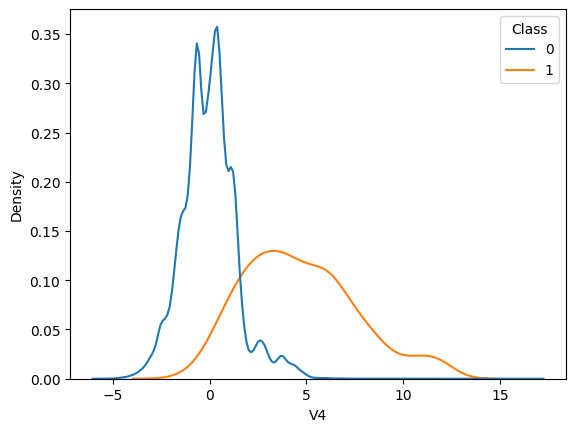

In [40]:
sns.kdeplot(data=data_train,x='V4', hue='Class', common_norm=False)

<Axes: xlabel='V10', ylabel='Density'>

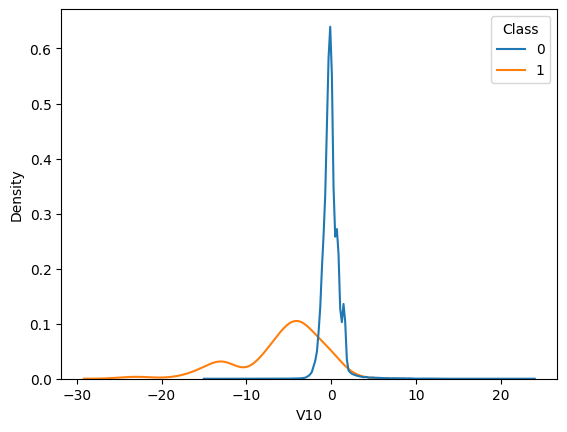

In [41]:
sns.kdeplot(data=data_train,x='V10', hue='Class', common_norm=False)

<Axes: xlabel='V1', ylabel='Density'>

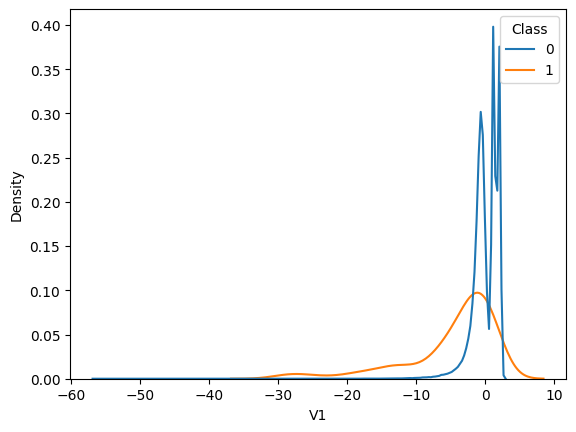

In [42]:
sns.kdeplot(data=data_train,x='V1', hue='Class', common_norm=False)

<Axes: xlabel='V4', ylabel='Density'>

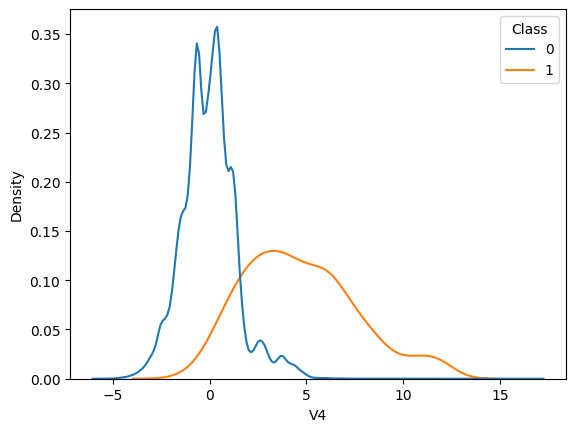

In [43]:
sns.kdeplot(data=data_train,x='V4', hue='Class', common_norm=False)

# Modeling

## Baseline Model 


In [44]:
from sklearn.linear_model import lasso_path, LogisticRegression
from src.model import undersampling, calc_metrics, roc_auc_curve, conf_mat
from itertools import cycle
import shap




c:\Users\thoma\AppData\Local\pypoetry\Cache\virtualenvs\fraud-detection-ofJXJpq--py3.9\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [45]:
model_baseline = LogisticRegression()

In [46]:
# X_train = data_resampled[sel_feat]
# y_train = data_resampled[TARGET]
X_train = data_train[FEATURES]
y_train = data_train[TARGET]

X_test = data_test[FEATURES]
y_test = data_test[TARGET]

model_baseline.fit(X_train,y_train)

c:\Users\thoma\AppData\Local\pypoetry\Cache\virtualenvs\fraud-detection-ofJXJpq--py3.9\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [47]:
y_pred = model_baseline.predict(X_test)
scores = model_baseline.predict_proba(X_test)[:,1]

In [48]:
data_test_scored = data_test.assign(y_pred = y_pred,
                                    scores = scores,
                                    y_true = y_test)

In [49]:
calc_metrics(data_test_scored)


,recall,precision,f1,auc,Cost
value,0.63,0.84,0.72,0.94,-6935.35


<Axes: xlabel='Predicted', ylabel='True'>

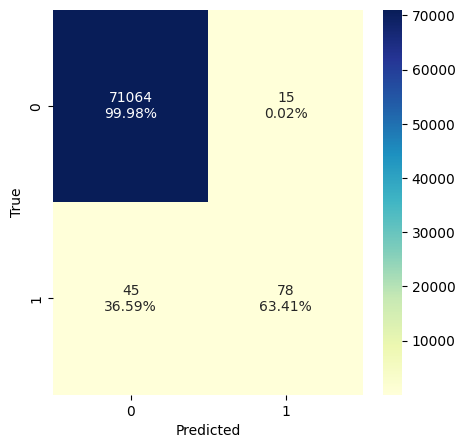

In [50]:
conf_mat(y_test, y_pred)

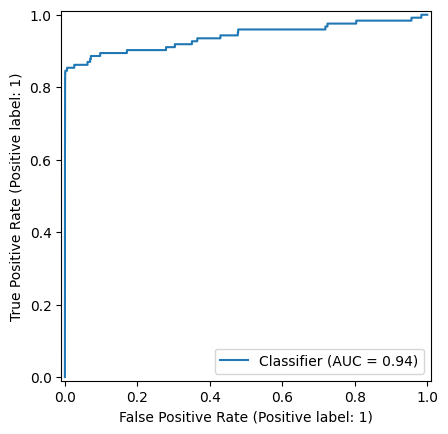

In [51]:
roc_auc_curve(y_test, scores)

## Undersampling
Undersample the majority class to balance the class proportion and make the classifier more stable.

In [52]:
data_resampled = undersampling(data_train,prop=0.1) 

In [53]:
X_train = data_resampled[FEATURES]
y_train = data_resampled[TARGET]

model_baseline.fit(X_train,y_train)

c:\Users\thoma\AppData\Local\pypoetry\Cache\virtualenvs\fraud-detection-ofJXJpq--py3.9\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [54]:
y_pred = model_baseline.predict(X_test)
scores = model_baseline.predict_proba(X_test)[:,1]

In [55]:
data_test_scored = data_test.assign(y_pred = y_pred,
                                    scores = scores,
                                    y_true = y_test)

In [56]:
calc_metrics(data_test_scored)


,recall,precision,f1,auc,Cost
value,0.81,0.63,0.71,0.97,-2166.47


<Axes: xlabel='Predicted', ylabel='True'>

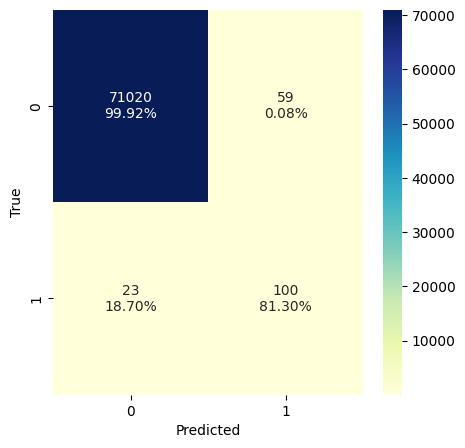

In [57]:
conf_mat(y_test, y_pred)

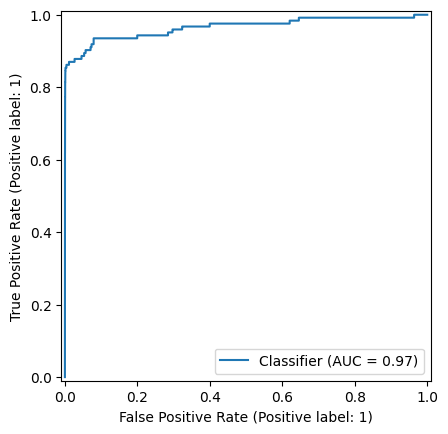

In [58]:
roc_auc_curve(y_test, scores)

## Boosting Model
Fit a catboost classifier to identify the frauds 

In [59]:
from catboost import CatBoostClassifier

In [60]:
X_train = data_train[FEATURES]
y_train = data_train[TARGET]

X_test = data_test[FEATURES]
y_test = data_test[TARGET]

In [61]:
clf  = CatBoostClassifier(auto_class_weights = 'Balanced', 
                          verbose = False)
clf.fit(X_train, y_train)

In [62]:
y_pred = clf.predict(X_test)
scores = clf.predict_proba(X_test)[:,1]

In [63]:
data_test_scored = data_test.assign(y_pred = y_pred,
                                    scores = scores,
                                    y_true = y_test)

In [64]:
calc_metrics(data_test_scored)


,recall,precision,f1,auc,Cost
value,0.84,0.74,0.78,0.98,-2098.42


<Axes: xlabel='Predicted', ylabel='True'>

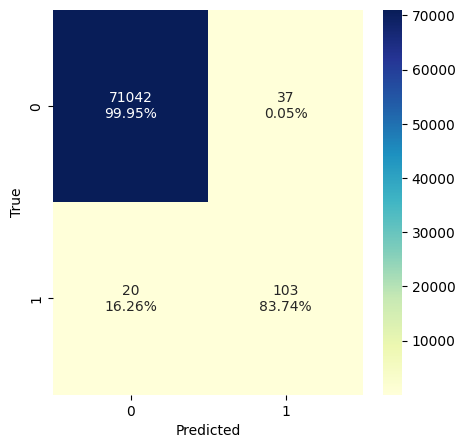

In [65]:
conf_mat(y_test, y_pred)

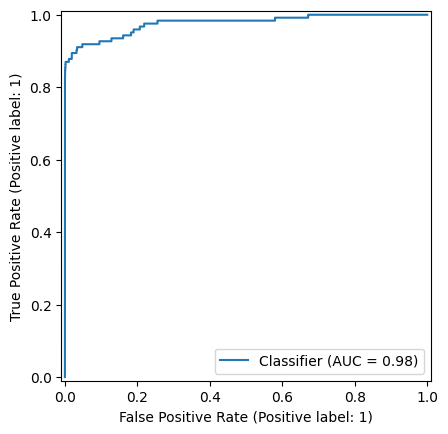

In [66]:
roc_auc_curve(y_test, scores)

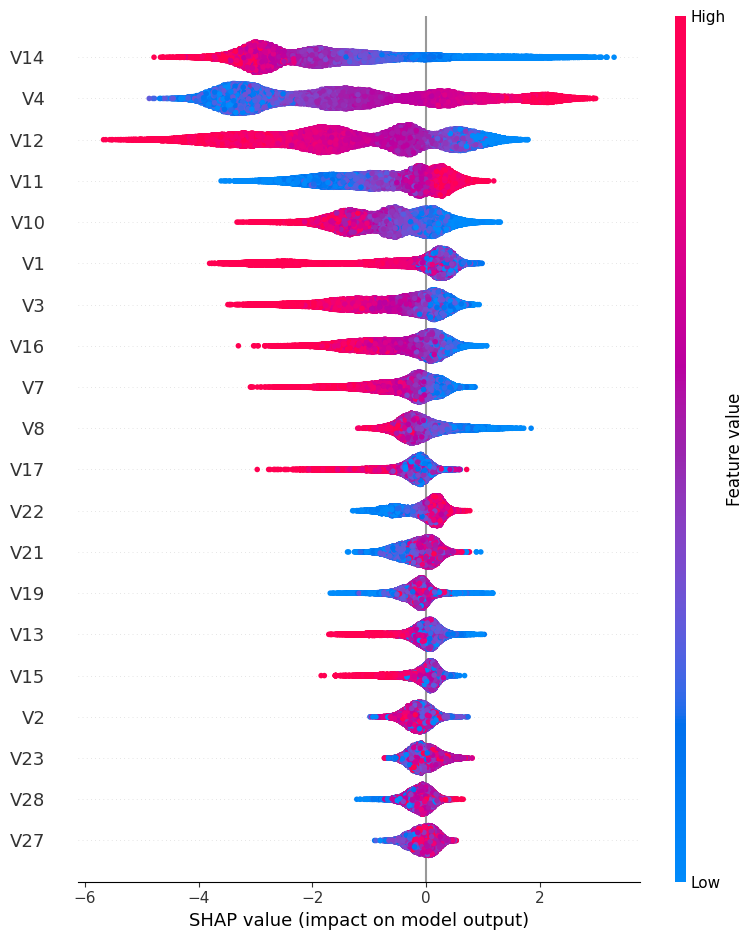

In [67]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

## Feature Engineering

### Time Hour
Interpret seconds from the first transaction as the hour (24h) that the transaction was made 

In [68]:
data_train['hour'] = data_train['time_hr']%24
data_test['hour'] = data_test['time_hr']%24


In [69]:
new_features = FEATURES+['hour']

In [70]:
X_train = data_train[new_features]
y_train = data_train[TARGET]

X_test = data_test[new_features]
y_test = data_test[TARGET]

In [71]:
clf  = CatBoostClassifier(auto_class_weights = 'Balanced', 
                          verbose = False)
clf.fit(X_train, y_train)

In [72]:
y_pred = clf.predict(X_test)
scores = clf.predict_proba(X_test)[:,1]

In [73]:
data_test_scored = data_test.assign(y_pred = y_pred,
                                    scores = scores,
                                    y_true = y_test)

In [74]:
calc_metrics(data_test_scored)


,recall,precision,f1,auc,Cost
value,0.85,0.80,0.82,0.97,-2072.56


<Axes: xlabel='Predicted', ylabel='True'>

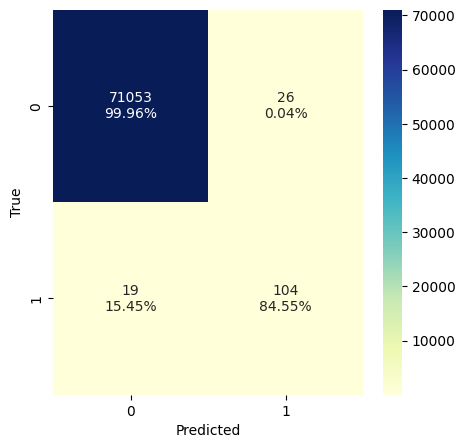

In [75]:
conf_mat(y_test, y_pred)

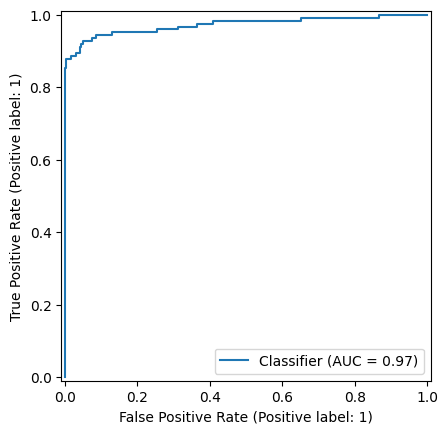

In [76]:
roc_auc_curve(y_test, scores)

### Distance Feature
Create a euclidean distance feature to center (mean and median) of the class (fraud or not fraud). All the features were used to calculate the distance 

In [77]:
df_frauds = data_train[data_train.Class==1]
df_no_frauds = data_train[data_train.Class==0]

In [78]:
centroid_n_fraud = df_no_frauds[FEATURES].mean()
centroid_fraud   = df_frauds[FEATURES].mean()
centroid_median_n_fraud = df_no_frauds[FEATURES].median()
centroid_median_fraud = df_frauds[FEATURES].median()

In [79]:
def calc_distance(df):
    data_points = df[FEATURES].values
    dist_n_fraud = np.linalg.norm(data_points-centroid_n_fraud.values)
    dist_fraud = np.linalg.norm(data_points-centroid_fraud.values)
    dist_median_n_fraud = np.linalg.norm(data_points-centroid_n_fraud.values)
    dist_median_fraud = np.linalg.norm(data_points-centroid_n_fraud.values)
    df = df.assign(dist_fraud = dist_fraud,
                   dist_n_fraud = dist_n_fraud,
                   dist_median_n_fraud = dist_median_n_fraud,
                   dist_median_fraud = dist_median_fraud)
    return df

In [80]:
data_train = calc_distance(data_train)
data_test =  calc_distance(data_test)

In [81]:
new_features = FEATURES + ['hour', 'dist_fraud', 'dist_n_fraud',
                           'dist_median_n_fraud', 'dist_median_fraud']

In [82]:
X_train = data_train[new_features]
y_train = data_train[TARGET]

X_test = data_test[new_features]
y_test = data_test[TARGET]

In [83]:
clf  = CatBoostClassifier(auto_class_weights = 'Balanced', 
                          verbose = False)
clf.fit(X_train, y_train)

In [84]:
y_pred = clf.predict(X_test)
scores = clf.predict_proba(X_test)[:,1]

In [85]:
data_test_scored = data_test.assign(y_pred = y_pred,
                                    scores = scores,
                                    y_true = y_test)

In [86]:
calc_metrics(data_test_scored)


,recall,precision,f1,auc,Cost
value,0.85,0.80,0.82,0.97,-2072.56


<Axes: xlabel='Predicted', ylabel='True'>

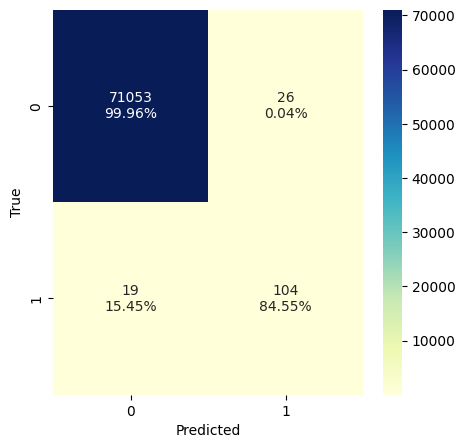

In [87]:
conf_mat(y_test, y_pred)

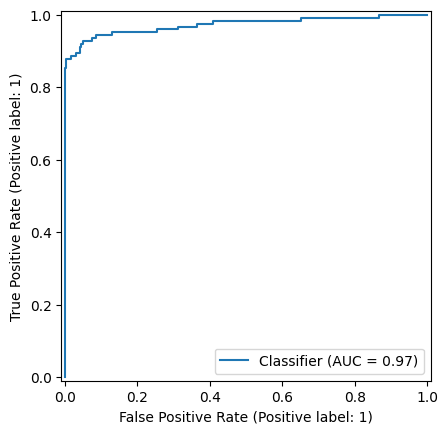

In [88]:
roc_auc_curve(y_test, scores)

In [89]:
clf.get_feature_importance(prettified=True)

,Feature Id,Importances
0,V14,10.388448
1,V4,7.991448
2,V1,6.148725
3,V3,5.615606
4,V12,5.151583
5,V11,4.659775
6,V17,4.144383
7,V8,3.955205
8,V7,3.805440
9,V16,3.206781


Distance features not improved model (feature importance = 0) but hour make it to the feature selection 

## Tuning Threshold
Tuned threshold using F1 score end up improving precision at the expense of lower recall, which is not good for the cost function

In [90]:
new_features = FEATURES + ['hour']

In [91]:
X_train = data_train[new_features]
y_train = data_train[TARGET]

X_test = data_test[new_features]
y_test = data_test[TARGET]

In [92]:
clf  = CatBoostClassifier(auto_class_weights = 'Balanced', 
                          verbose = False)

In [93]:
from sklearn.model_selection import TunedThresholdClassifierCV

In [108]:
clf_tuned = TunedThresholdClassifierCV(clf,scoring="f1_micro").fit(X_train,y_train)


In [109]:
clf_tuned.best_threshold_

0.9898915510867115

In [110]:
y_pred = clf_tuned.predict(X_test)
scores = clf_tuned.predict_proba(X_test)[:,1]

In [111]:
data_test_scored = data_test.assign(y_pred = y_pred,
                                    scores = scores,
                                    y_true = y_test)

In [112]:
calc_metrics(data_test_scored)


,recall,precision,f1,auc,Cost
value,0.76,0.94,0.84,0.97,-4747.80


<Axes: xlabel='Predicted', ylabel='True'>

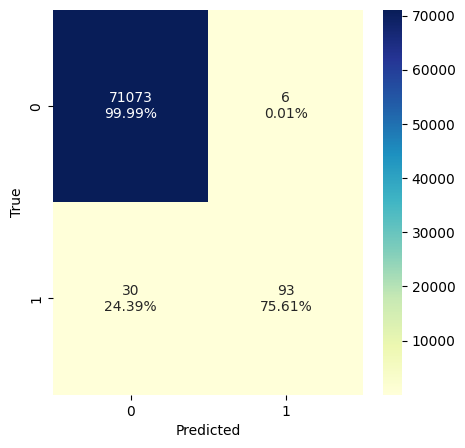

In [113]:
conf_mat(y_test, y_pred)

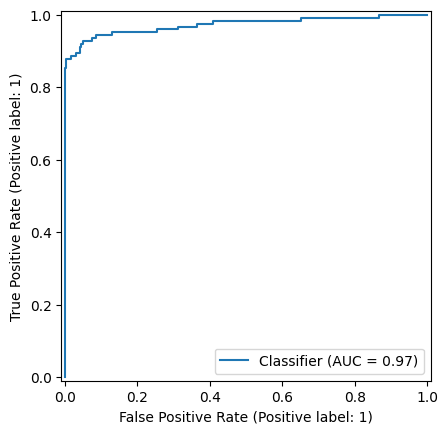

In [114]:
roc_auc_curve(y_test, scores)

## False Positive and False Negative Analysis

In [138]:
fp_mask = (data_test_scored.y_true==1)&(data_test_scored.y_pred==0)

In [140]:
def map_conf_matrix(data):
    if (data.y_true==1)&(data.y_pred==0):
        return 'fn'
    elif (data.y_true==0)&(data.y_pred==0):
        return 'tn'
    elif (data.y_true==1)&(data.y_pred==1):
        return 'tp'
    elif (data.y_true==0)&(data.y_pred==1):
        return 'fp'
    else:
        return 'error'

In [141]:
data_test_scored['pred_status'] = data_test_scored.apply(map_conf_matrix,axis=1)

<Axes: xlabel='V4', ylabel='V14'>

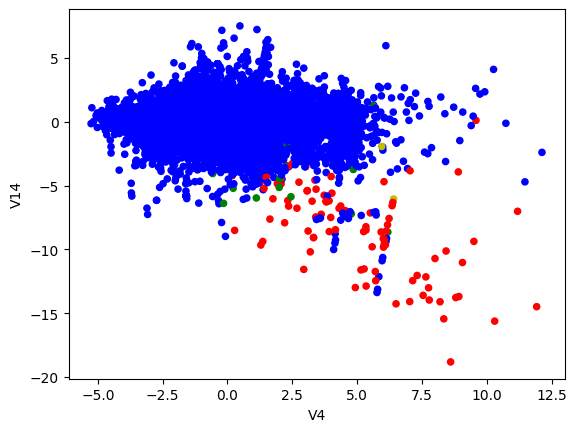

In [146]:
col = data_test_scored.pred_status.map({"tn":'b',"tp":'r','fp':'y','fn':'g'})
data_test_scored.plot.scatter(x="V4",y="V14",c=col)


## Calibration 
This step calibrate the previous classifier in order to guarantee that the output of the model can be interpreted as a probability.

In [122]:
from sklearn.calibration import CalibrationDisplay, CalibratedClassifierCV

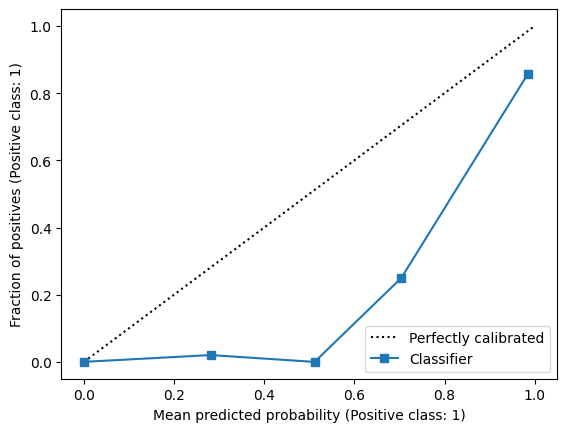

In [444]:
CalibrationDisplay.from_predictions(y_test,scores)

In [446]:
calibrated_clf = CalibratedClassifierCV(clf, cv=3)


In [447]:
calibrated_clf.fit(X_train, y_train)

CalibratedClassifierCV(cv=3,
                       estimator=<catboost.core.CatBoostClassifier object at 0x00000175E0CC5AC0>)

In [448]:
scores = calibrated_clf.predict_proba(X_test)[:,1]

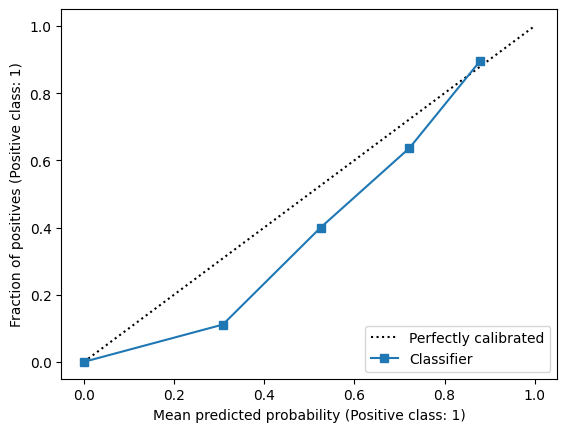

In [449]:
CalibrationDisplay.from_predictions(y_test,scores)

In [450]:
pd.Series(scores).describe()

count    71202.000000
mean         0.001786
std          0.035190
min          0.000286
25%          0.000287
50%          0.000287
75%          0.000287
max          0.883958
dtype: float64

# Train and Save Model

In [115]:
import joblib

In [117]:
data['hour'] = data['time_hr']%24

In [118]:
X = data[new_features]
y = data[TARGET]

In [119]:
clf  = CatBoostClassifier(auto_class_weights = 'Balanced', 
                          verbose = False)

In [120]:
clf.fit(X,y)

In [123]:
calibrated_clf = CalibratedClassifierCV(clf, cv=3)


In [124]:
calibrated_clf.fit(X, y)

CalibratedClassifierCV(cv=3,
                       estimator=<catboost.core.CatBoostClassifier object at 0x000002EDAFD40E80>)

In [125]:
joblib.dump(clf, "../assets/model_clf.joblib")

['../assets/model_clf.joblib']

In [126]:
joblib.dump(calibrated_clf, "../assets/model_score.joblib")

['../assets/model_score.joblib']

# Test API

In [127]:
import requests
import json

In [128]:

with open("../assets/sample.json") as f: 
    sample = json.load(f)

In [130]:
requests.get('http://127.0.0.1:8000/predict',data=json.dumps(sample)).json()

{'id': 'S001', 'prediction': 'Not Fraud'}

In [132]:
with open("../assets/sample_fraud.json") as f: 
    sample = json.load(f)

In [133]:
r = requests.get('http://127.0.0.1:8000/predict',data=json.dumps(sample))

In [134]:
r.json()

{'id': 'S002', 'prediction': '84.429%'}